### Setup

In [10]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use("seaborn-notebook")

### Load Dataset

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

### Randomization

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13791,-122.0,37.4,16.0,3015.0,829.0,1769.0,807.0,4.0,249.5
198,-116.4,33.7,10.0,11836.0,2405.0,3811.0,1570.0,4.0,134.5
11489,-121.2,38.0,46.0,2001.0,428.0,1384.0,401.0,1.9,62.2
1460,-117.2,32.8,33.0,5226.0,833.0,2221.0,839.0,5.1,207.0
196,-116.4,34.1,6.0,2104.0,348.0,841.0,320.0,4.1,116.3
...,...,...,...,...,...,...,...,...,...
914,-117.1,32.6,28.0,2296.0,603.0,1277.0,550.0,2.4,123.8
11268,-121.1,37.7,11.0,3886.0,599.0,1605.0,529.0,4.4,182.7
10371,-120.2,37.1,29.0,1995.0,392.0,1261.0,354.0,1.9,79.2
3841,-118.0,34.0,34.0,1428.0,227.0,890.0,249.0,5.9,204.8


### Examine the Statistics of Dataset

In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Input Function

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Model Function

In [6]:
def train_model(learning_rate, steps, batch_size, input_feature):
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')
    
    # Create input_fns
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, shuffle=False, num_epochs=1)
    
    # Create feature_columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create linear_regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )
    
    # Plot the model's line for each period
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learning Line by Period\n")
    plt.xlabel(my_feature)
    plt.ylabel(my_label)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, 10)]
    
    # Train the model in a loop
    print("Training model...")
    print("  RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # Train the model, starting from prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        # Compute predicitons
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        print("    Period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Track the weights and bias
        y_extents = np.array([0, sample[my_label].max()])
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished.")
    
    # Graph of loss metrics
    plt.subplot(1, 2, 2)
    plt.title("Root Mean Squared Error vs. Period\n")
    plt.xlabel("Periods")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Create a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data['Predictions'] = pd.Series(predictions)
    calibration_data['Targets'] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %s" % root_mean_squared_error)
    
    # Indentify Outliers and plot Histogram of rooms_per_person
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    # plt.title("Identify Outliers\n")
    plt.scatter(calibration_data["Predictions"], calibration_data["Targets"])
    plt.subplot(1, 2, 2)
    # plt.title("Histogram of Rooms_per_Person\n")
    california_housing_dataframe["rooms_per_person"].hist()

### Synthetic Feature

Training model...
  RMSE (on training data):
    Period 00 : 212.73
    Period 01 : 189.63
    Period 02 : 168.95
    Period 03 : 151.69
    Period 04 : 139.77
    Period 05 : 133.19
    Period 06 : 131.09
    Period 07 : 130.88
    Period 08 : 131.13
    Period 09 : 131.72
Model training finished.


,Predictions,Targets
count,17000.0,17000.0
mean,195.8,207.3
std,89.9,116.0
min,44.8,15.0
25%,160.5,119.4
50%,192.7,180.4
75%,220.1,265.0
max,4290.0,500.0


Final RMSE (on training data): 131.72366909557294


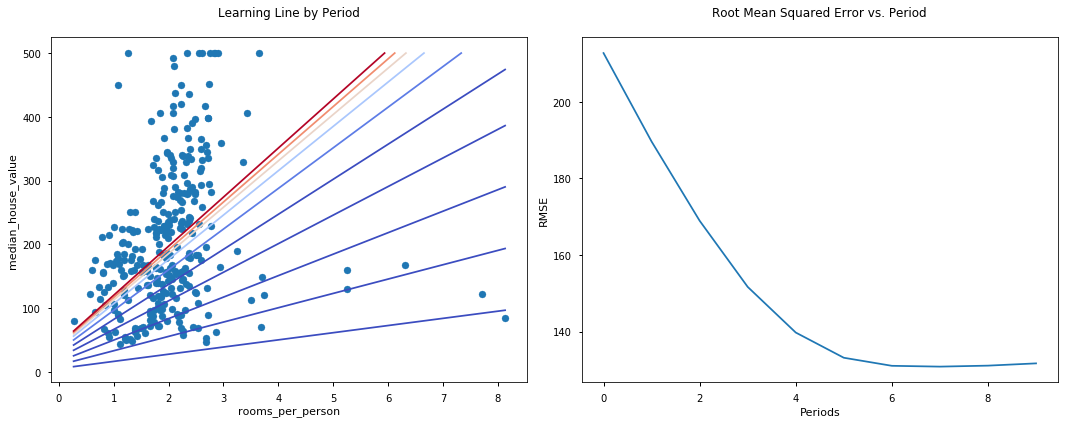

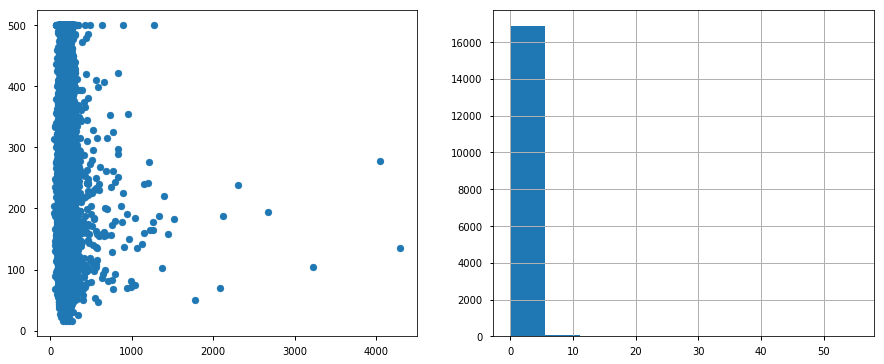

In [7]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

### Removal of Outliers

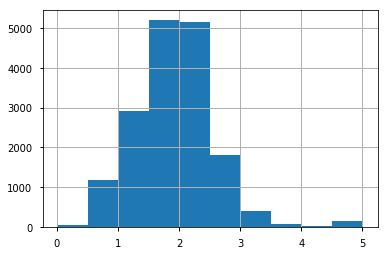

In [8]:
# Clipping the feature: 'rooms_per_person'.
# The above histogram show, majority of values are greater than 5, and we clipped it till 5.
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))
california_housing_dataframe["rooms_per_person"].hist()
plt.show()

### Final Model without Outliers

Training model...
  RMSE (on training data):
    Period 00 : 212.79
    Period 01 : 189.02
    Period 02 : 166.65
    Period 03 : 146.34
    Period 04 : 130.18
    Period 05 : 118.74
    Period 06 : 112.88
    Period 07 : 110.52
    Period 08 : 109.33
    Period 09 : 108.52
Model training finished.


,Predictions,Targets
count,17000.0,17000.0
mean,192.7,207.3
std,50.4,116.0
min,44.8,15.0
25%,160.5,119.4
50%,192.7,180.4
75%,220.1,265.0
max,427.9,500.0


Final RMSE (on training data): 108.52245861312532


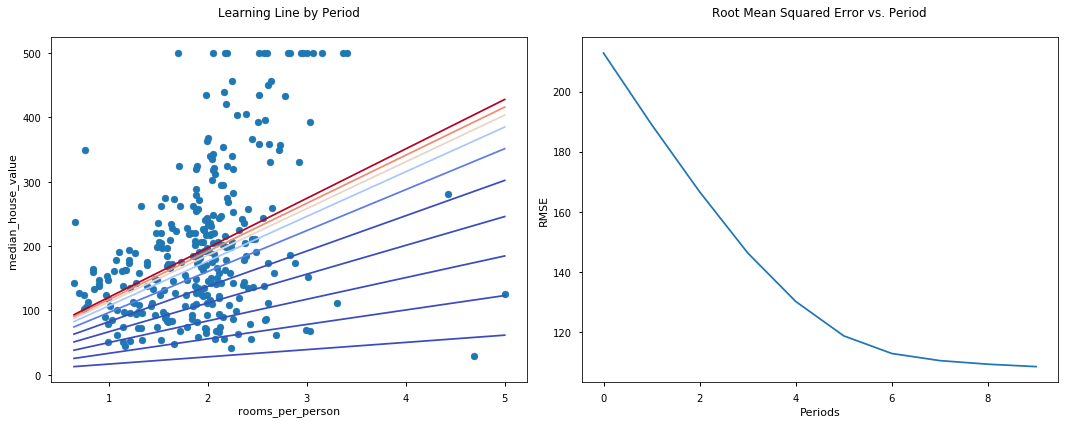

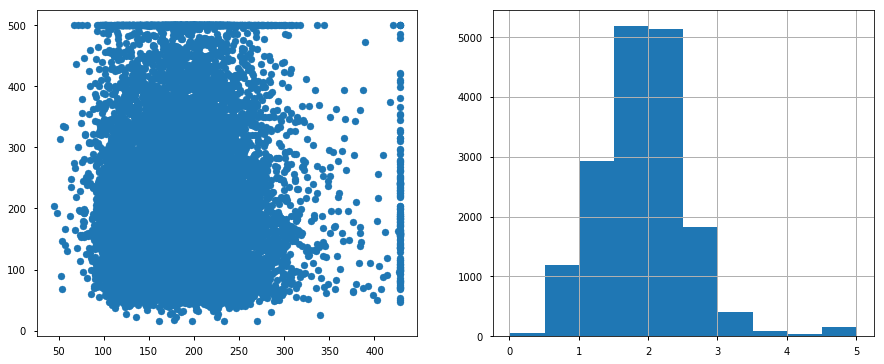

In [9]:
calibration_plot = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)